In [170]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

import torch.distributions as tdist

from ipywidgets import interact

$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit test: Making sure that code works
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

0: mu=tensor([0.1001, 0.8999]), sigma=0.8999549746513367, negelbo=1.5305336713790894
500: mu=tensor([0.1387, 0.8613]), sigma=0.8657623529434204, negelbo=1.2861064672470093
1000: mu=tensor([0.1772, 0.8228]), sigma=0.8327990770339966, negelbo=1.1186916828155518
1500: mu=tensor([0.2136, 0.7864]), sigma=0.8026116490364075, negelbo=0.8903730511665344
2000: mu=tensor([0.2481, 0.7518]), sigma=0.7748115062713623, negelbo=0.8628026247024536
2500: mu=tensor([0.2811, 0.7188]), sigma=0.749034583568573, negelbo=0.621742844581604
3000: mu=tensor([0.3128, 0.6871]), sigma=0.7249778509140015, negelbo=0.5323859453201294
3500: mu=tensor([0.3433, 0.6566]), sigma=0.7023874521255493, negelbo=0.3982437551021576
4000: mu=tensor([0.3729, 0.6271]), sigma=0.6810635924339294, negelbo=0.32242271304130554
4500: mu=tensor([0.4016, 0.5984]), sigma=0.6608493328094482, negelbo=0.18833713233470917
5000: mu=tensor([0.4296, 0.5704]), sigma=0.6416165828704834, negelbo=0.2180633395910263
5500: mu=tensor([0.4569, 0.5431]), s

45500: mu=tensor([0.5637, 0.4344]), sigma=0.08304090797901154, negelbo=0.013373609632253647
46000: mu=tensor([0.5856, 0.4127]), sigma=0.08109414577484131, negelbo=0.05016934126615524
46500: mu=tensor([0.6046, 0.3941]), sigma=0.07919301092624664, negelbo=0.06894434988498688
47000: mu=tensor([0.6194, 0.3796]), sigma=0.07734321802854538, negelbo=0.07581331580877304
47500: mu=tensor([0.6279, 0.3717]), sigma=0.07553903013467789, negelbo=0.07124315947294235
48000: mu=tensor([0.6259, 0.3747]), sigma=0.0737820416688919, negelbo=0.12418486922979355
48500: mu=tensor([0.6083, 0.3934]), sigma=0.07206951826810837, negelbo=0.11245106160640717
49000: mu=tensor([0.5781, 0.4241]), sigma=0.0704023614525795, negelbo=0.12661422789096832
49500: mu=tensor([0.5448, 0.4574]), sigma=0.06877648085355759, negelbo=0.10562895983457565
50000: mu=tensor([0.5131, 0.4889]), sigma=0.06719594448804855, negelbo=0.09777870029211044
50500: mu=tensor([0.4840, 0.5179]), sigma=0.06565552204847336, negelbo=0.16182582080364227


91000: mu=tensor([0.4652, 0.5341]), sigma=0.19694766402244568, negelbo=-0.4146566390991211
91500: mu=tensor([0.4747, 0.5259]), sigma=0.2020011842250824, negelbo=-0.4320593476295471
92000: mu=tensor([0.5064, 0.4946]), sigma=0.20718364417552948, negelbo=-0.43782421946525574
92500: mu=tensor([0.5301, 0.4705]), sigma=0.21248695254325867, negelbo=-0.4445354640483856
93000: mu=tensor([0.5288, 0.4711]), sigma=0.21792492270469666, negelbo=-0.4431256353855133
93500: mu=tensor([0.4990, 0.4999]), sigma=0.22348926961421967, negelbo=-0.4437592625617981
94000: mu=tensor([0.4730, 0.5268]), sigma=0.22919423878192902, negelbo=-0.4481338858604431
94500: mu=tensor([0.4712, 0.5295]), sigma=0.235032320022583, negelbo=-0.4475458562374115
95000: mu=tensor([0.4990, 0.5014]), sigma=0.2410154491662979, negelbo=-0.4495702385902405
95500: mu=tensor([0.5260, 0.4742]), sigma=0.24713990092277527, negelbo=-0.4499739408493042
96000: mu=tensor([0.5283, 0.4718]), sigma=0.25341305136680603, negelbo=-0.4482326805591583
96

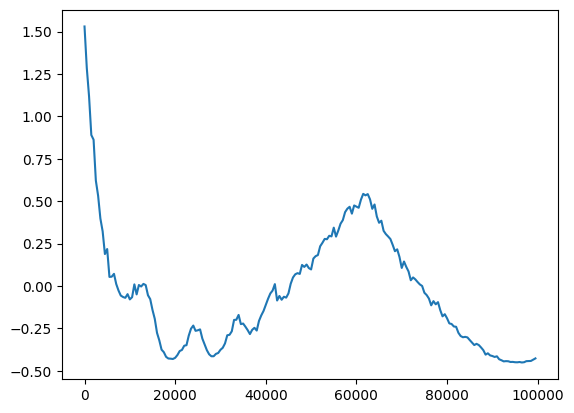

In [182]:
mu_0 = torch.tensor([0.5, 0.5])
sigma_0 = torch.tensor([0.5])

mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
logsigma = nn.Parameter(torch.tensor([np.log(0.9)], dtype=torch.float))
lr = 0.00005
optim = torch.optim.Adam([mu, logsigma], lr=lr)
num_epoch = 100000
S = 2000


rec = []
for epoch in range(num_epoch):
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(logsigma))
    xi = q.rsample((S, ))
    term1 = q.log_prob(xi)
    term2 = torch.sum((xi - mu_0)**2, dim=1) / (2 * sigma_0**2)
    neg_elbo = torch.mean(term1 + term2)
    neg_elbo.backward()
    optim.step()
    
    if epoch % 500 == 0:
        print(f"{epoch}: mu={mu.detach()}, sigma={torch.exp(logsigma).item()}, negelbo={neg_elbo}")
        rec.append((epoch, neg_elbo.detach()))
rec = np.array(rec)
plt.plot(rec[:, 0], rec[:, 1])

In [174]:
mu = nn.Parameter(torch.tensor([0.5, 0.5]))
logsigma = nn.Parameter(torch.tensor([np.log(0.9)]))
optim = torch.optim.SGD([mu, logsigma], lr=0.0001)

q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * sigma)
xi = q.rsample((20, ))


tensor([[ 1.1560,  1.3841],
        [ 2.5061,  1.0345],
        [ 1.0563, -0.1402],
        [ 2.3896,  0.8519],
        [ 1.4072, -0.0600],
        [ 0.2538, -0.7068],
        [ 1.0606,  0.4373],
        [ 2.0594,  0.0208],
        [-0.7130,  0.9368],
        [ 0.1691, -2.3851],
        [ 0.6361,  1.1237],
        [-0.1620,  0.5209],
        [-0.6892,  1.3305],
        [ 0.1083, -0.7228],
        [-1.5169, -0.7154],
        [ 0.3064,  0.5576],
        [-0.7567, -0.6787],
        [-0.7509,  1.2373],
        [ 0.9709, -0.9608],
        [ 1.3601,  0.7127]], grad_fn=<AddBackward0>)

# Experiment 1: Learning 2D standard form posterior

We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [126]:
N = 200
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))


@interact(
    n=(2, 10000),
    k1=(0, 5),
    k2=(0, 5),
    h1=(0, 5),
    h2=(0, 5)
)
def _plot_contour(n=5, k1=2, k2=1, h1=1, h2=1):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z = (xx ** h1) * (yy ** h2) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
    normalising_const = np.sum(z) / (N**2)
    
    lambdas = np.array([(h1 + 1) / (2 * k1), (h2 + 1) / (2 * k2)])
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    print(
        f"-logZ = {-np.log(normalising_const)}\n"
        f"RLCT= {rlct}\n"
        f"m={m}\n"
        f"rlct log(n) - (m - 1) log log n= {rlct * np.log(n) - (m -1) * np.log(np.log(n))}"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=5, description='n', max=10000, min=2), IntSlider(value=2, description='k…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

## Gaussian Variational Family
We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\nabla_\theta \elbo(q_\theta) = \nabla_\theta -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
$$

In [135]:
mu = torch.tensor([.5, .5], requires_grad=True)
logsigma = torch.tensor([np.log(0.9)], requires_grad=True)
lr = 0.0005
optim = torch.optim.SGD([mu, logsigma], lr=lr)
num_epoch = 50
S = 20000
n = 2

k = torch.tensor([2, 1])
h = torch.tensor([1, 1])
for epoch in range(num_epoch):
    q_eps = tdist.MultivariateNormal(torch.zeros(2), torch.eye(2)) 
    eps = q_eps.rsample((S, ))
    xi = mu + torch.exp(logsigma) * eps
    term1 = n * torch.mean(torch.prod(xi**k, dim=1))
    term2 = 2 * logsigma - torch.mean(torch.sum(torch.log(xi) * h, dim=1))
    neg_elbo = term1 + term2
    neg_elbo.backward()
    optim.step()
    
    print(f"{epoch}: mu={mu.detach()}, sigma={torch.exp(logsigma).item()}")


0: mu=tensor([0.4996, 0.4991]), sigma=0.8992097560069962
1: mu=tensor([0.4997, 0.4883]), sigma=0.9012345848777339
2: mu=tensor([0.4995, 0.4740]), sigma=0.9035485304993867
3: mu=tensor([0.4990, 0.4587]), sigma=0.905114037459982
4: mu=tensor([0.4966, 0.4416]), sigma=0.9069159676328323
5: mu=tensor([0.4941, 0.4233]), sigma=0.9079626245326816
6: mu=tensor([0.4913, 0.4043]), sigma=0.9082208173394033
7: mu=tensor([0.4883, 0.3847]), sigma=0.9076373685930434
8: mu=tensor([0.4857, 0.3633]), sigma=0.9064216338041458
9: mu=tensor([0.4830, 0.3414]), sigma=0.9044688276159966
10: mu=tensor([0.4686, 0.3169]), sigma=0.9073973487828088
11: mu=tensor([0.4531, 0.2943]), sigma=0.9093391271189668
12: mu=tensor([0.4765, 0.2674]), sigma=0.8957315576624149
13: mu=tensor([0.5004, 0.2398]), sigma=0.8815433341392471
14: mu=tensor([0.5253, 0.2117]), sigma=0.8666189110894572
15: mu=tensor([0.5510, 0.1817]), sigma=0.8513414565772438
16: mu=tensor([0.5772, 0.1513]), sigma=0.8357846762980596
17: mu=tensor([0.6038, 0.

Text(0, 0.5, '$\\xi_2$')

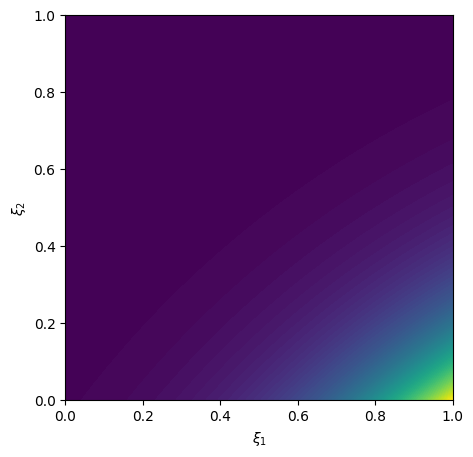

In [136]:
with torch.no_grad():
    sigma = torch.exp(logsigma)
    q = tdist.MultivariateNormal(mu, torch.eye(2) * sigma)
#     q = tdist.MultivariateNormal(torch.tensor([0.5, 0.3]), torch.eye(2) * 0.1)
    N = 50
    xx, yy = torch.meshgrid(torch.linspace(0, 1, steps=50), torch.linspace(0, 1, steps=50))
    z = q.log_prob(torch.stack((xx, yy), dim=-1))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.contourf(xx, yy, torch.exp(z), levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")

In [77]:
q.log_prob(torch.tensor([0.1, 0.5]))

tensor(-684.1006, grad_fn=<SubBackward0>)

tensor([[-709.7518, -708.4135, -707.0778,  ..., -649.5218, -648.2994,
         -647.0795],
        [-711.0580, -709.7199, -708.3842,  ..., -650.8281, -649.6058,
         -648.3859],
        [-712.3668, -711.0286, -709.6929,  ..., -652.1368, -650.9144,
         -649.6945],
        ...,
        [-773.8115, -772.4733, -771.1376,  ..., -713.5816, -712.3592,
         -711.1393],
        [-775.2336, -773.8954, -772.5598,  ..., -715.0037, -713.7813,
         -712.5615],
        [-776.6582, -775.3200, -773.9843,  ..., -716.4283, -715.2059,
         -713.9860]], grad_fn=<SubBackward0>)